In [1]:
import gym
import numpy as np
import random
from IPython.display import clear_output
import matplotlib
from matplotlib import pyplot as plt
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In this notebook, I am implementing hill climb algorithm. For the implementation, I am using $CartPole-V1$ environment.

Hill Climbing Algorithm is a local search algorithm which continuously moves in the direction of increasing value to find the peak of the mountain or best possible solution for the problem. It terminates when it reaches a peak where no neighour has a higher value. This techniques also known as greedy search as it only looks to its immediate neighour with higher value not beyond that. It mostly used when a good huristic is available. This approach is similar to travelling saleman problem where the salesman is trying to find the best route with minimal travel distance. 


In [2]:
# Defining the Environment Name
env_name = 'CartPole-v1'

In [3]:
# Environment Utility and Initialization class

class Environment(gym.wrappers.time_limit.TimeLimit):
    
    def __init__(self, env_name, *args, **kwargs):
        super(Environment, self).__init__(gym.make(env_name,  *args, **kwargs))
        self.print_env()
    
    def print_env(self):
        print("Environment Name: ", self.spec.name)
        print("Action Space Type: ", "DISCRETE" if type(self.action_space) == gym.spaces.discrete.Discrete else "CONTINUOUS" )
        print("Observation Space Type: ", "DISCRETE" if type(self.observation_space) == gym.spaces.discrete.Discrete else "CONTINUOUS" )
        print("Observation Space: ", self.observation_space)
        
    def __del__(self):
        self.close()

In [4]:
env = Environment(env_name, render_mode="human")

Environment Name:  CartPole
Action Space Type:  DISCRETE
Observation Space Type:  CONTINUOUS
Observation Space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [5]:
class GenericAgent:
    
    def __init__(self, env: gym.wrappers.time_limit.TimeLimit):
        action_space = env.action_space

        # Action Space
        if type(action_space) == gym.spaces.discrete.Discrete:
            self.action_size = action_space.n
            self.action_type = "DISCRETE"
            self.action_space = np.arange(action_space.n)
        else:
            self.action_type = "CONTINUOUS"
            self.action_low = action_space.low
            self.action_high = action_space.high
            self.action_size = action_space.shape
        
        
        # Observation Type
        obs_space = env.observation_space
        if type(obs_space) == gym.spaces.discrete.Discrete:
            self.observation_type = "DISCRETE"
            self.observation_size = obs_space.n
        else:
            self.observation_type = "CONTINUOUS"
            self.observation_low = obs_space.low
            self.observation_high = obs_space.high
            self.observation_size = obs_space.shape
        
    
    def get_random_action(self, state = None):
        
        if self.action_type == "DISCRETE":
            return np.random.choice(self.action_space)
        else:
            return np.random.uniform(low=self.action_low, high=self.action_high, size=self.action_shape)

In [6]:
def plot_data(episode_duration, lr_data, total_reward, show_result=False):
    f = plt.figure(figsize=(20, 10))
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    
    ax = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)
    ax.set_ylabel('Duration')
    ax2.set_ylabel("Learning Rate")
    ax3.set_ylabel("Episode Reward")
    ax.plot(episode_duration )
    ax2.plot(lr_data)
    ax3.plot(total_reward)
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)
#     if is_ipython:
#         if not show_result:
#             display.display(plt.gcf())
#             display.clear_output(wait=True)
#         else:
#             display.display(plt.gcf())

### Implementing HillClimbing Algorithm 

Steps for Hill Climbing Algorithm

1. Initialize the weight matrix with minimum numbers. Matrix Size = (# observations x # actions)
2. Define the 
    - best_weights = initial_weights
    - best_reward = -inf
    - learning_rate = 1e-4
3. Iteraction until episode ends
    - Select an action and take a step
    - Store total reward from the episode
    - update the weights based on total rewards
        ```
        if best_reward < total_reward
        then 
            best_weights = current_weights
            best_reward = total_reward
            learning_rate /= 2
        else
        then 
            learning_rate *= 2
        endif
        update weights
        current_weights = best_weights + learning_rate * random(#observations x #actions)
        ```


In [24]:
class HillClimbAgent(GenericAgent):
    
    def __init__(self, env):
        super(HillClimbAgent, self).__init__(env)
        self.initialize_weights()
        
    def initialize_weights(self):
        self.weights = 1e-4 * np.random.randn(self.observation_size[0], self.action_size)
        self.best_weights = np.copy(self.weights)
        self.best_reward = -np.inf
        self.learning_rate = 1e-2
        
    def get_action(self, state):
        p_state = np.dot(state, self.weights)
        return np.argmax(p_state)
    
    def update_model(self, reward):
        
        if reward > self.best_reward:
            self.best_weights = np.copy(self.weights)
            self.best_reward = reward
            self.learning_rate = max(self.learning_rate / 2, 1e-3)
        else:
            self.learning_rate = min(self.learning_rate*2, 2)
        
        self.weights = self.best_weights + self.learning_rate * np.random.randn(self.observation_size[0], self.action_size)

In [32]:
agent = HillClimbAgent(env)

In [33]:
N_EPOCHS = 10
lr_data = []
episode_duration = []
reward_history = []

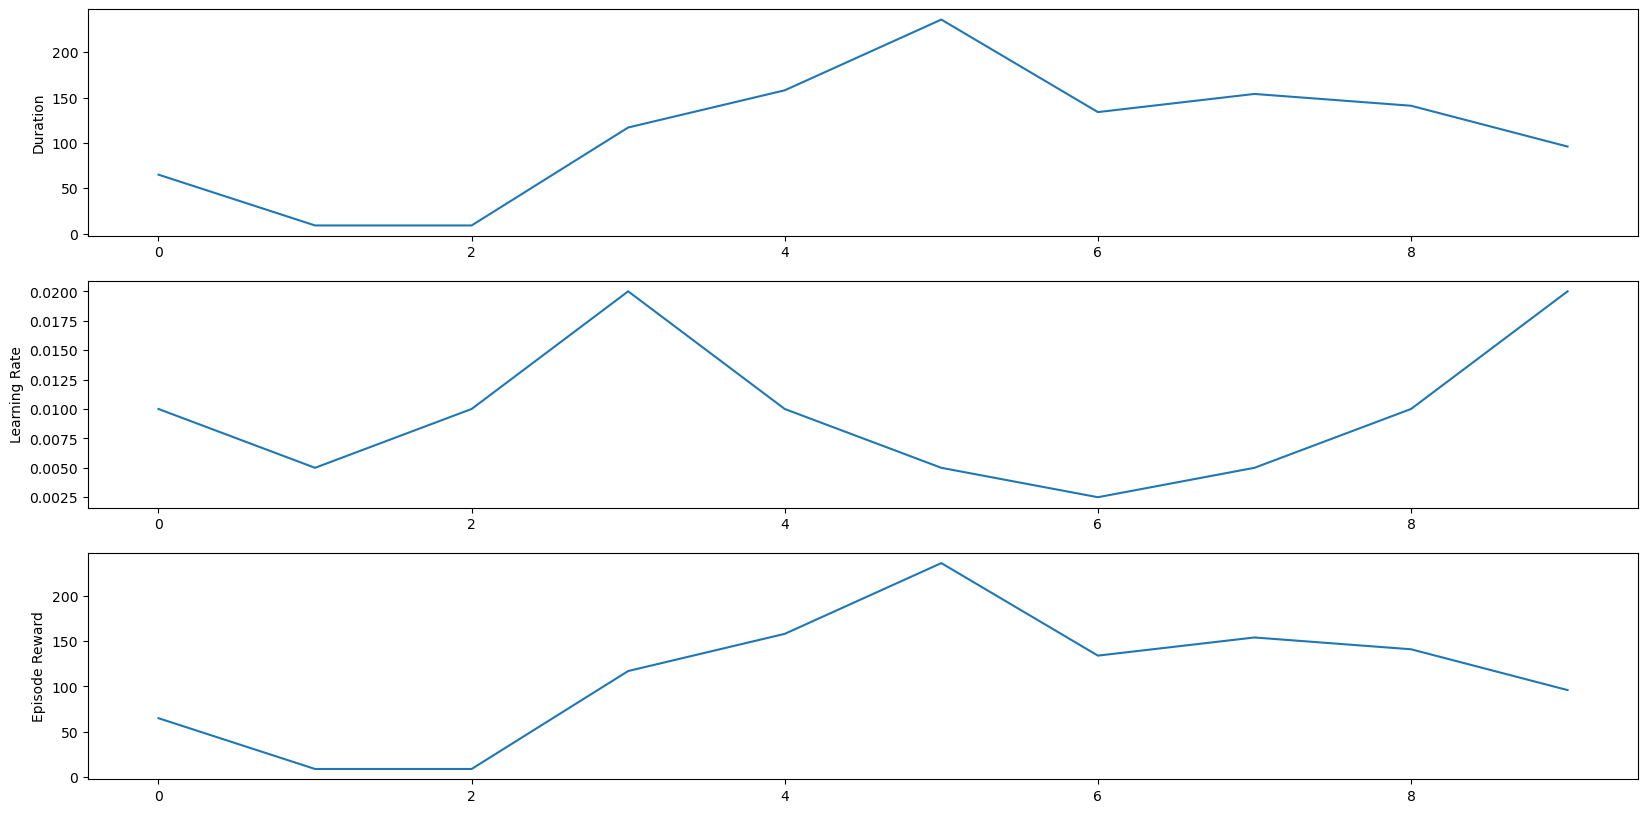

In [34]:
for epoch in range(N_EPOCHS):
    
    obs, _= env.reset()
    done = False
    total_reward = 0
    duration = 0
    while not done:
        action = agent.get_action(obs)
        obs, reward, terminate, trunc, _ = env.step(action)
        done = terminate or trunc
        duration += 1
        total_reward += reward
    lr_data.append(agent.learning_rate)
    episode_duration.append(duration)
    reward_history.append(total_reward)
    plot_data(episode_duration, lr_data, reward_history)
    agent.update_model(total_reward)
plot_data(episode_duration, lr_data, reward_history, True)
